In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from lingua import LanguageDetectorBuilder
import matplotlib.pyplot as plt
import geopandas as gpd
import math


In [12]:
listings_url = './data/listings-09-2022.csv'
listings_raw=pd.read_csv(listings_url)

## Convert price to numeric format

In [13]:
listings_raw["price"] = pd.to_numeric(listings_raw["price"].str.replace(r'[$,]', "", regex = True))

## Write neighbourhood_cleansed value into neighbourhood column

In [14]:
listings_raw["neighbourhood"] = listings_raw["neighbourhood_cleansed"]
listings_raw["neighbourhood_group"] = listings_raw["neighbourhood_group_cleansed"]

## Drop listings without reviews

In [ ]:
count_of_listings_with_reviews = len(listings_raw[listings_raw["number_of_reviews"] > 0])
count_of_listings_without_reviews = len(listings_raw[listings_raw["number_of_reviews"] == 0])
print("Listings with reviews: ", count_of_listings_with_reviews)
print("Listings without reviews: ", count_of_listings_without_reviews)

Listings with reviews:  13812
Listings without reviews:  2868


In [15]:
listings_with_reviews = listings_raw[listings_raw["number_of_reviews"] > 0]

## Add separate fields for smoke and carbon monoxide detectors

In [ ]:
carbon_monoxide_substring = 'Carbon monoxide alarm'
smoke_alarm_substring = 'Smoke alarm'
listings_with_reviews.loc[:, 'has_smoke_alarm'] = listings_with_reviews["amenities"].str.contains(smoke_alarm_substring)
listings_with_reviews.loc[:, 'has_co_alarm'] = listings_with_reviews["amenities"].str.contains(carbon_monoxide_substring)

/tmp/ipykernel_9149/340655119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_with_reviews.loc[:, 'has_smoke_alarm'] = listings_with_reviews["amenities"].str.contains(smoke_alarm_substring)
/tmp/ipykernel_9149/340655119.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_with_reviews.loc[:, 'has_co_alarm'] = listings_with_reviews["amenities"].str.contains(carbon_monoxide_substring)


## Drop listings without beds

In [ ]:
count_of_listings_without_beds = len(listings_with_reviews[listings_with_reviews["beds"].isnull()])
count_of_listings_with_beds = len(listings_with_reviews[listings_with_reviews["beds"].notnull()])
print("Listings without information about beds: ", count_of_listings_without_beds)
print("Listings with information about beds: ", count_of_listings_with_beds)

Listings without information about beds:  234
Listings with information about beds:  13578


In [ ]:
listings_with_beds = listings_with_reviews[listings_with_reviews["beds"].notnull()]

## Drop listings without bedrooms

In [ ]:
count_of_listings_without_bedrooms = len(listings_with_reviews[listings_with_reviews["bedrooms"].isnull()])
count_of_listings_with_bedrooms = len(listings_with_reviews[listings_with_reviews["bedrooms"].notnull()])
print("Listings without information about bedrooms: ", count_of_listings_without_bedrooms)
print("Listings with information about bedrooms: ", count_of_listings_with_bedrooms)

Listings without information about bedrooms:  1109
Listings with information about bedrooms:  12703


In [ ]:
listings_with_bedrooms = listings_with_reviews[listings_with_reviews["bedrooms"].notnull()]

In [ ]:
def get_fitted_X(X, polynomial_degree: int):
    poly_reg=PolynomialFeatures(degree=polynomial_degree)
    X_poly=poly_reg.fit_transform(X)
    return X_poly

def get_linear_regression_model(X, y, polynomial_degree: int):
    X_poly_fitted=get_fitted_X(X, polynomial_degree)
    lin_reg_model=LinearRegression()
    lin_reg_model.fit(X_poly_fitted,y)
    return lin_reg_model

def get_mse(X_train, y_train, X_test, y_test, polynomial_degree: int):
    lin_reg_model = get_linear_regression_model(X_train, y_train, polynomial_degree)
    X_test_poly_fitted=get_fitted_X(X_test, polynomial_degree)
    y_predicted = lin_reg_model.predict(X_test_poly_fitted)
    return mean_squared_error(y_test, y_predicted)

def get_r2_score(X_train, y_train, X_test, y_test, polynomial_degree: int):
    lin_reg_model = get_linear_regression_model(X_train, y_train, polynomial_degree)
    X_test_poly_fitted=get_fitted_X(X_test, polynomial_degree)
    y_predicted = lin_reg_model.predict(X_test_poly_fitted)
    return r2_score(y_test, y_predicted)

def print_mse_and_r2_plots(range: range, mse_list: list, r2_list: list, title = ''):
    fig, ax = plt.subplots(2, sharex=True)
    if title != '':
        fig.suptitle(title)
    ax[0].plot(range, mse_list, color='blue')
    ax[0].set_xlabel('Polynomial regression degree')
    ax[0].set_ylabel('mean squared error')
    ax[0].set_yscale('log')
    ax[1].plot(range, r2_list, color='red')
    ax[1].set_xlabel('Polynomial regression degree')
    ax[1].set_ylabel('R² score')
    ax[1].set_yscale('log')

In [ ]:
relevant_columns = [
  "neighbourhood", 
  "property_type", 
  "room_type", 
  "accommodates", 
  "has_smoke_alarm", 
  "has_co_alarm",
  "beds"
]

X_beds=listings_with_beds[relevant_columns].values
y_beds=listings_with_beds["price"].values

In [ ]:
X_beds_train,X_beds_test,y_beds_train,y_beds_test=train_test_split(X_beds,y_beds,test_size=0.2,random_state=0)

In [ ]:
mse_list = []
r2_list = []

degree_range = range(1, 11)

X = X_beds
y = y_beds

for polynomial_degree in degree_range:
    mse = get_mse(X_train=X, X_test=X, y_train=y, y_test=y, polynomial_degree=polynomial_degree)
    mse_list.append(mse)
    r2 = get_r2_score(X_train=X, X_test=X, y_train=y, y_test=y, polynomial_degree=polynomial_degree)
    r2_list.append(r2)

print_mse_and_r2_plots(range=degree_range, mse_list=mse_list, r2_list=r2_list)

ValueError: could not convert string to float: 'Zehlendorf  Südwest'

# Playing around with NLP and the reviews

In [2]:
reviews_url = './data/reviews-09-2022.csv'
reviews_raw = pd.read_csv(reviews_url)

In [3]:
reviews_filtered = reviews_raw[reviews_raw["comments"].notna()]

In [4]:
"""
detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()

reviews_language = reviews_filtered.copy()
for i, row in reviews_language.iterrows():
    if i % 100 == 0:
      print("Now processing iteration ", i)
    confidence_values = detector.compute_language_confidence_values(row["comments"])
    language_lowercase = str(confidence_values[0].language).split(".")[1].lower()
    reviews_language.at[i,'language_detected'] = language_lowercase
    reviews_language.at[i,'language_confidence'] = confidence_values[0].value

reviews_language_url = './data/reviews-09-2022-language.csv'
reviews_language.to_csv(reviews_language_url, index=False, sep=";", lineterminator="\r")
"""

'\ndetector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()\n\nreviews_language = reviews_filtered.copy()\nfor i, row in reviews_language.iterrows():\n    if i % 100 == 0:\n      print("Now processing iteration ", i)\n    confidence_values = detector.compute_language_confidence_values(row["comments"])\n    language_lowercase = str(confidence_values[0].language).split(".")[1].lower()\n    reviews_language.at[i,\'language_detected\'] = language_lowercase\n    reviews_language.at[i,\'language_confidence\'] = confidence_values[0].value\n\nreviews_language_url = \'./data/reviews-09-2022-language.csv\'\nreviews_language.to_csv(reviews_language_url, index=False, sep=";", lineterminator="\r")\n'

The custom line terminator `\r` is necessary because some of the comments have linebreaks (`\n`) which break the interpretation of the csv file.

In [5]:
reviews_language_url = './data/reviews-09-2022-language.csv'
reviews_language_read = pd.read_csv(reviews_language_url, sep=";", lineterminator="\r")

In [6]:
min_required_confidence = 0.6
reviews_confident_language = reviews_language_read[reviews_language_read["language_confidence"] > min_required_confidence]
language_occurencies = reviews_confident_language.groupby(by="language_detected").size()
top_10_languages = language_occurencies.sort_values(ascending=False).head(10)
top_10_languages

language_detected
english    251904
german     116793
french      17428
spanish     11216
dutch        4991
italian      4316
russian      2862
chinese      1643
korean       1577
danish       1474
dtype: int64

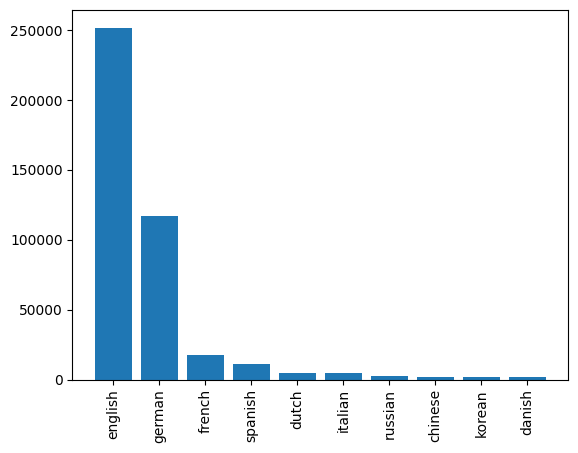

In [7]:
labels = top_10_languages.keys()
sizes = top_10_languages.values

fig1, ax1 = plt.subplots()
ax1.bar(labels, sizes)
plt.xticks(rotation=90)
plt.show()

In [8]:
berlin_neighbourhoods_url = "./data/neighbourhoods-09-2022.geojson"
berlin_neighbourhoods_raw = gpd.read_file(berlin_neighbourhoods_url)
berlin_neighbourhoods_raw[berlin_neighbourhoods_raw["neighbourhood"].isnull()]

,neighbourhood,neighbourhood_group,geometry
11,None,None,"MULTIPOLYGON (((13.61659 52.58154, 13.61458 52..."
12,None,None,"MULTIPOLYGON (((13.61668 52.57868, 13.60703 52..."


<AxesSubplot: >

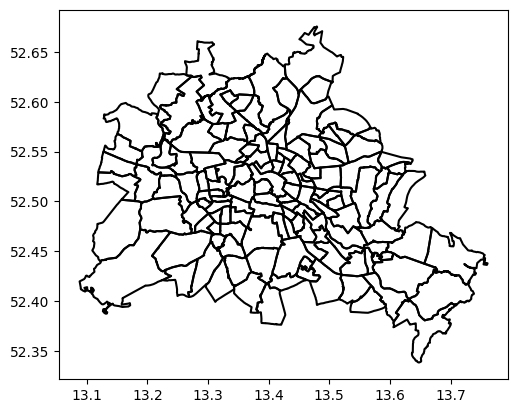

In [9]:
berlin_neighbourhoods = berlin_neighbourhoods_raw[berlin_neighbourhoods_raw["neighbourhood"].notnull()]
berlin_neighbourhoods.boundary.plot(color="black")

In [43]:
def get_neighbourhoods_and_review_counts_for_language(language):
  listings_and_neighbourhoods = berlin_neighbourhoods.merge(listings_with_reviews, on="neighbourhood", how="right")
  listings_and_neighbourhoods = listings_and_neighbourhoods.rename(columns={"id": "listing_id"})

  language_reviews = reviews_confident_language[reviews_confident_language["language_detected"] == language]
  language_listings_and_neighbourhoods = language_reviews.merge(listings_and_neighbourhoods, on="listing_id")
  language_review_counts = language_listings_and_neighbourhoods.groupby(by="neighbourhood").size().reset_index(name='counts')
  
  return berlin_neighbourhoods.merge(language_review_counts, how="left").fillna(0)

def plot_review_counts_per_neighbourhood_for_multiple_language(languages: list[str]):
  rows_count = math.ceil(len(languages) / 2)
  fig, axs = plt.subplots(nrows=rows_count, ncols=2, figsize=(15, 15))

  ravelled_axes = axs.ravel()

  if len(ravelled_axes) > len(languages):
    fig.delaxes(ravelled_axes[-1])

  for (index, language), ax in zip(enumerate(languages), ravelled_axes):
    language_data = get_neighbourhoods_and_review_counts_for_language(language)
    
    ax.plot = language_data.plot(column = "counts", ax = ax, cmap="afmhot", legend=True, label = "Foo")
    ax.set_title(language)
  
  fig.suptitle("Number of reviews in the respective language per neighbourhood", fontsize=22)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()


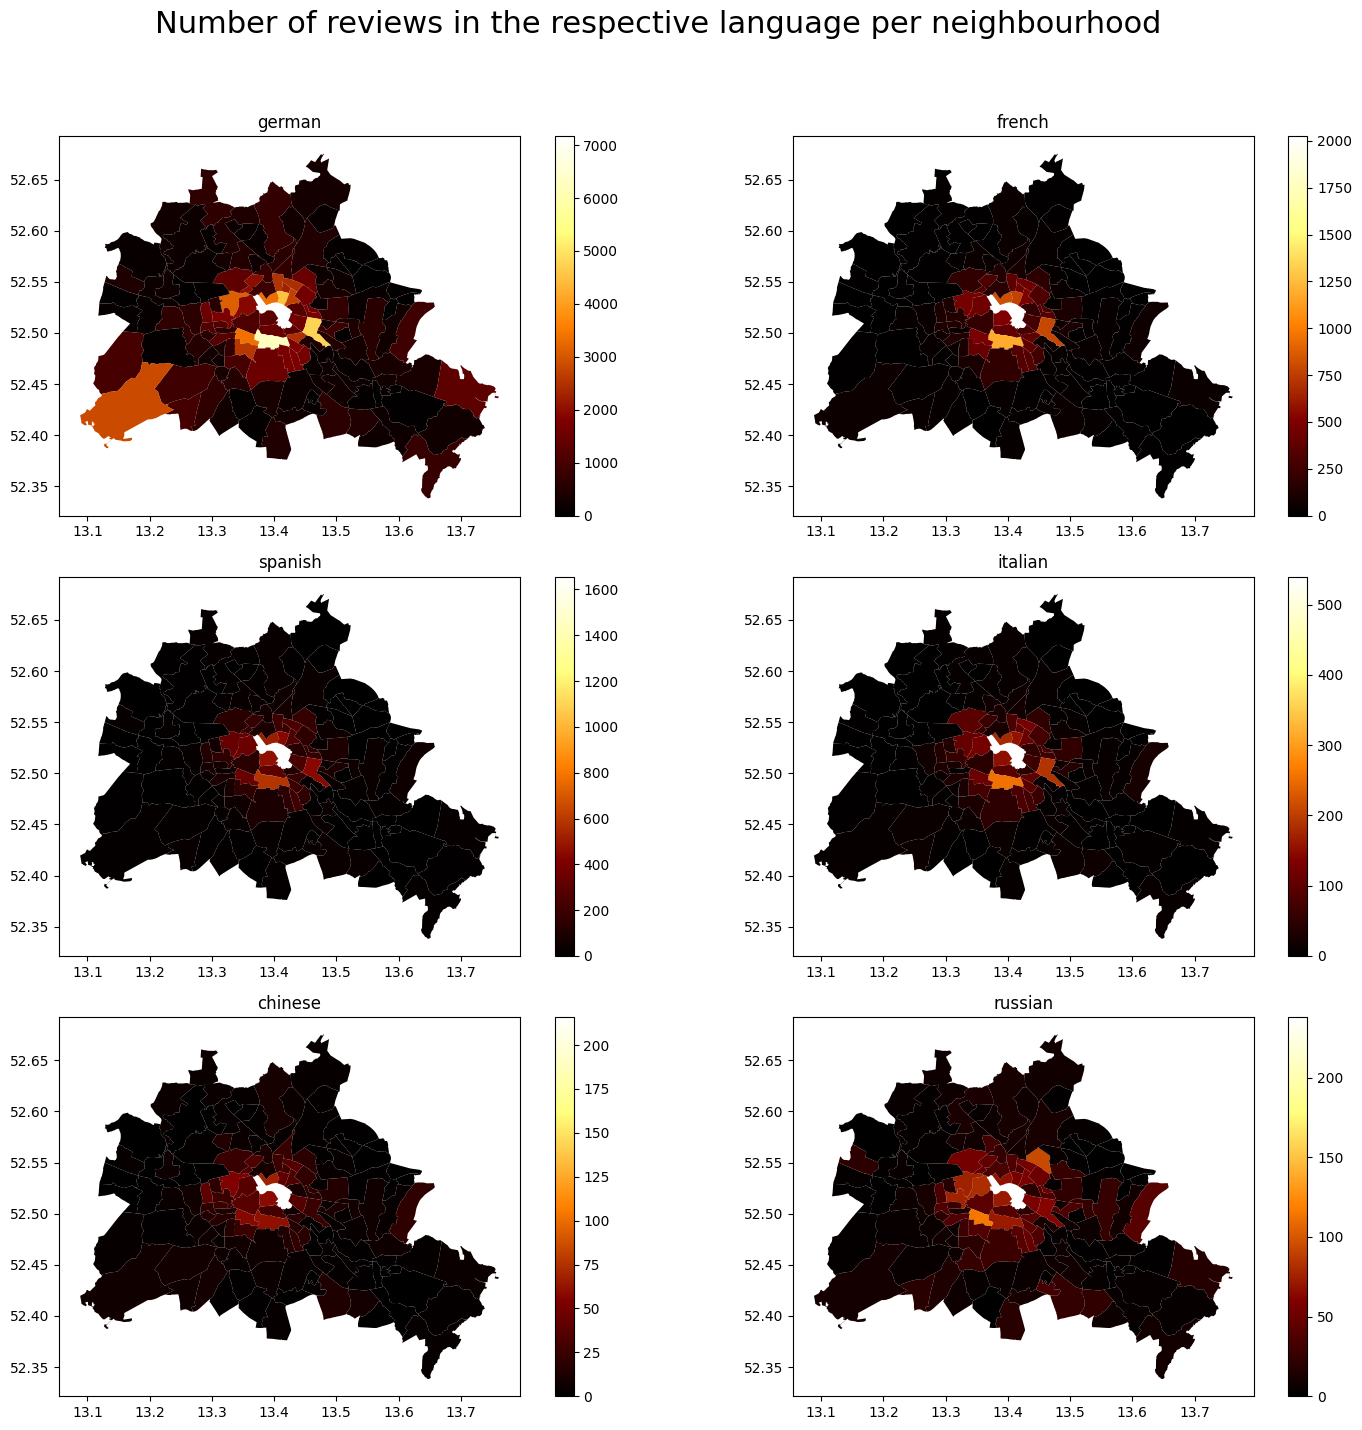

In [44]:
languages = ["german", "french", "spanish", "italian", "chinese", "russian"]
plot_review_counts_per_neighbourhood_for_multiple_language(languages)